# Vehicle Collisions in New York City in 2018-2019

Author: **Marcin Sikorski**<br>
Date: December, 2021

This simple notebook aims to creating Heatmaps with time lapse. The idea of writing this project came while encountering a New York City motor vehicle collisions dataset. I decided to try some spatial visualization and represent time lapse on Heatmaps with car crashes in NYC. Figures were created with <code>folium</code> base maps which allows us to browse them in an interactive manner in HTML.

**Report Content:**<br>
1. Loading, Examining, and Reducing Dataset<br>
2. Basic Visualizing<br>
3. Generating Heatmaps<br>
    3.1 Monthly Time Lapse<br>
    3.2 Time Lapse Throughout the Day<br>
4. Conclusions

**Motor Vehicle Collisions - Crashes Description**<br>
The data was collected from Open Data [NYC Open Data][1]. Open Data is free public data published by New York City agencies and other partners. All users have free access to datasets by categories, agencies, trends, e.t.c.<br>
The Motor Vehicle Collisions crash table contains details on the crash event. Each row represents a crash event. It is updated daily and provided by New York City Police Department (NYPD) [Downloaded 23rd of December 2021]. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. Since we are focused on spatial visualzing and time lapse, our main interest are geographical coordinates and crash dates.

[1]:https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95 'NYC Open Data'

### 1. Loading, Examining, and Reducing Dataset

We will load data from CSV file in chunks - the dataset has lots of rows.

In [1]:
import pandas as pd
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

data_chunks = []
data = []
chunksize = 100000

# load dataset as chunks
for chunk in pd.read_csv('vehicle_collisions.csv', chunksize=chunksize, sep=';'):
    data_chunks.append(chunk)

data = pd.concat(data_chunks, ignore_index=True)

In [2]:
# transpose to see whole header
data.head().T

,0,1,2,3,4
CRASH DATE,04/14/2021,04/13/2021,04/15/2021,04/13/2021,04/12/2021
CRASH TIME,5:32,21:35,16:15,16:00,8:25
BOROUGH,NaN,BROOKLYN,NaN,BROOKLYN,NaN
ZIP CODE,NaN,11217,NaN,11222,NaN
LATITUDE,NaN,40.6836,NaN,NaN,0
LONGITUDE,NaN,-73.9762,NaN,NaN,0
LOCATION,NaN,"(40.68358, -73.97617)",NaN,NaN,"(0.0, 0.0)"
ON STREET NAME,BRONX WHITESTONE BRIDGE,NaN,HUTCHINSON RIVER PARKWAY,VANDERVORT AVENUE,EDSON AVENUE
CROSS STREET NAME,NaN,NaN,NaN,ANTHONY STREET,NaN
OFF STREET NAME,NaN,620 ATLANTIC AVENUE,NaN,NaN,NaN


In [3]:
# number of rows and columns
data.shape

(1851812, 29)

This is a very big dataset. Since we are interested in geospatial visualizing and analyzing, we will examine <code>LATITUDE</code> and <code>LONGITUDE</code> columns in dataframe, and get rid of NaN or incorrect values. We are not able to replace them with real values and removing them won't affect furture results.

In [4]:
# return number of rows with NaN
data[['LATITUDE', 'LONGITUDE']].isna().sum()

LATITUDE     215976
LONGITUDE    215976
dtype: int64

In [5]:
# filter out not null rows
data = data[data['LATITUDE'].notnull()]

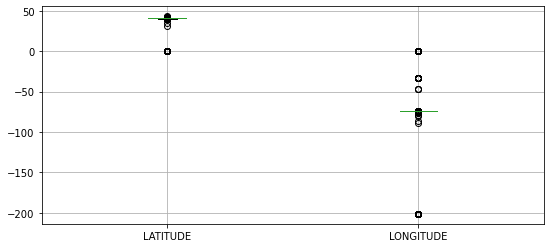

In [6]:
# boxplot for better overview
data.boxplot(column=['LATITUDE', 'LONGITUDE'], figsize=(9,4))

In [7]:
# get rid of rows with zero
data = data.loc[(data['LATITUDE'] != 0)]

# filter out rows in range
data = data.loc[(data['LONGITUDE'] <= -50) & (data['LONGITUDE'] >= -200)]

In [8]:
# summarize columns
data[['LATITUDE', 'LONGITUDE']].describe().applymap(lambda x: f'{x:.3f}').transpose()

,count,mean,std,min,25%,50%,75%,max
LATITUDE,1633571.000,40.724,0.079,30.784,40.669,40.722,40.769,43.344
LONGITUDE,1633571.000,-73.920,0.088,-89.135,-73.976,-73.928,-73.867,-73.663


In [9]:
# display data types for each column
data.dtypes

CRASH DATE                        object
CRASH TIME                        object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
COLLISION_ID                       int64
VEHICLE TYPE COD

This dataframe still has over 1.63M rows. We will extract rows for years 2018 and 2019.
Before that, let's convert <code>CRASH DATE</code> column to its right data type.

In [10]:
# convert column into date
data['CRASH DATE']= pd.to_datetime(data['CRASH DATE'])

# count rows per year
import datetime as dt
data.groupby(data['CRASH DATE'].dt.year).count()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,85458,85458,77575,77575,85458,85458,85458,76841,76834,741,...,76238,5736,1169,300,85458,85453,76220,5734,1169,300
2013,171933,171933,155973,155973,171933,171933,171933,155068,155053,919,...,152086,11583,2406,582,171933,171830,154229,11641,2412,587
2014,172738,172738,156344,156344,172738,172738,172738,154345,154318,2030,...,149762,10647,2180,565,172738,172093,155332,10896,2229,576
2015,182980,182980,163453,163431,182980,182980,182980,161091,161058,3969,...,160459,11722,2451,630,182980,182932,166452,11912,2496,638
2016,192160,192160,136563,136526,192160,192160,192160,144569,106399,44249,...,164666,12213,2623,660,192160,189858,156879,11414,2364,590
2017,216927,216927,138451,138405,216927,216927,216927,165217,100764,51537,...,185653,13743,2886,776,216927,215642,173084,13072,2768,749
2018,216109,216109,144564,144527,216109,216109,216109,162315,105275,53394,...,183146,13748,2872,758,216109,214759,171345,13063,2733,727
2019,193819,193819,132882,132839,193819,193819,193819,144414,95758,49382,...,162775,12633,2695,739,193819,192488,152235,12087,2614,720
2020,103812,103812,71490,71482,103812,103812,103812,75251,49087,28561,...,81094,9763,2674,798,103812,102789,72080,9206,2558,774


In [11]:
# extract rows with years 2018 and 2019
data = data[(data['CRASH DATE'].dt.year >= 2018) & (data['CRASH DATE'].dt.year <= 2019)]

# optional method
#df = data[(data['CRASH DATE'] >= '2018-01-01') & (data['CRASH DATE'] <= '2019-12-31')]

In [12]:
# check unique years in column
print(data['CRASH DATE'].dt.year.unique())

# display dimensions
print(data.shape)

[2019 2018]
(409928, 29)


### 2. Basic Visualizing

The dataset is almost ready. We want to plot vehicle collisions in time, so we will create new time columns for greater detail. We can easily extract this data from <code>CRASH DATE</code> column using <code>datetime</code> library.<br>
To make our future Heatmaps we want to keep rows in calender order, using <code>sort_values</code> function will sort rows alphabetically. To keep it as simple as possible, we will implement these steps:

1. Create <code>year</code> and <code>month</code> columns for dataframe.
2. Separate dataset into two dataframes by year.
3. Sort rows ascending in each dataframe by <code>month</code> column (from 1 to 12).
4. Concatenate (stack) our objects along each other.
5. Finally, get month names and combine <code>month_name</code> and <code>year</code> columns.

In [13]:
# create new 'year' and 'month' columns
data['year'] = data['CRASH DATE'].dt.year
data['month'] = data['CRASH DATE'].dt.month

# separate dataset by year
df_2018 = data[(data['CRASH DATE'].dt.year == 2018)]
df_2019 = data[(data['CRASH DATE'].dt.year == 2019)]

# sort values asc by 'month'
df_2018 = df_2018.sort_values(['month'], ascending=True)
df_2019 = df_2019.sort_values(['month'], ascending=True)

# concatenate into 1 dataframe
frames = [df_2018, df_2019]
df = pd.concat(frames, join='outer')

# new column with month name
month_list = []
for i in df['month']:
    month_int = i
    month_list.append(dt.date(1900, month_int, 1).strftime('%B'))

df['month_name'] = month_list

# combine year and month name
df['month_year'] =  df['month_name'] + ', ' + df['year'].astype(str)

In [14]:
# check results
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,year,month,month_name,month_year
663307,2018-01-17,5:49,BROOKLYN,11222,40.725880,-73.941696,"(40.72588, -73.941696)",NASSAU AVENUE,KINGSLAND AVENUE,NaN,...,3829741,Sedan,Sedan,NaN,NaN,NaN,2018,1,January,"January, 2018"
651157,2018-01-19,16:00,STATEN ISLAND,10305,40.598557,-74.081764,"(40.598557, -74.081764)",NORWAY AVENUE,HYLAN BOULEVARD,NaN,...,3831404,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,2018,1,January,"January, 2018"
651156,2018-01-13,23:57,BROOKLYN,11216,40.682365,-73.945040,"(40.682365, -73.94504)",NaN,NaN,205 HALSEY STREET,...,3828678,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018,1,January,"January, 2018"
651155,2018-01-16,8:30,NaN,NaN,40.653180,-74.005610,"(40.65318, -74.00561)",4 AVENUE,NaN,NaN,...,3829845,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018,1,January,"January, 2018"
651154,2018-01-05,9:45,NaN,NaN,40.866820,-73.839230,"(40.86682, -73.83923)",EAST GUN HILL ROAD,KINGSLAND AVENUE,NaN,...,3822792,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,2018,1,January,"January, 2018"


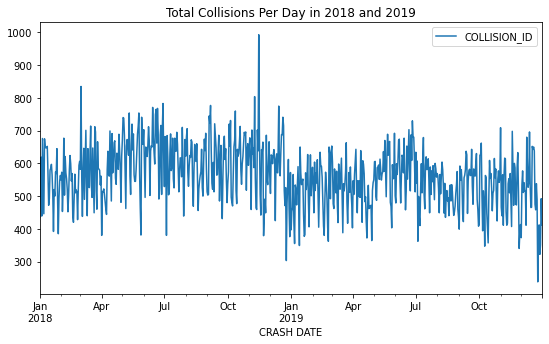

In [15]:
# time series of collisions
total_collisions = pd.pivot_table(df, index='CRASH DATE', values='COLLISION_ID', aggfunc='count')

# plot results
total_collisions.plot(title='Total Collisions Per Day in 2018 and 2019', figsize=(9,5))

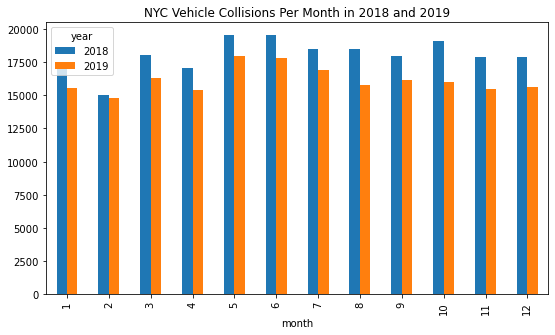

In [16]:
# count collisions per month using pivot table
pt = pd.pivot_table(df, index='month', columns='year', values='COLLISION_ID', aggfunc='count')

# visualize results
pt.plot.bar(title='NYC Vehicle Collisions Per Month in 2018 and 2019', figsize=(9,5))

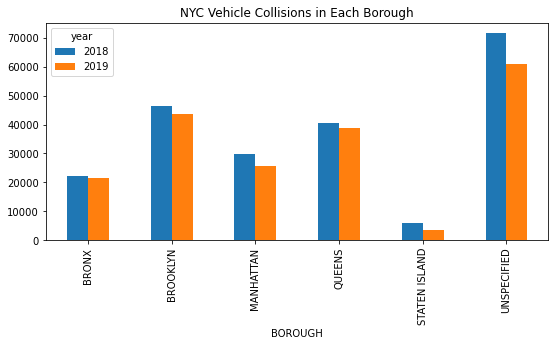

In [17]:
# fill NaN cells with 'UNSPECIFIED'
df['BOROUGH'].fillna('UNSPECIFIED', inplace=True)

# count collisions in each Borough
borough_collisions = pd.pivot_table(df, index='BOROUGH', columns='year', values='COLLISION_ID', aggfunc='count')

# plot results
borough_collisions.plot.bar(title='NYC Vehicle Collisions in Each Borough', figsize=(9,4))

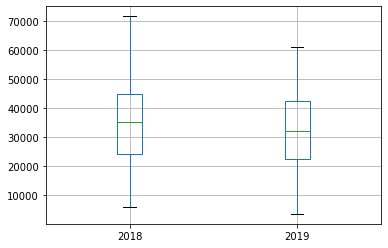

In [18]:
# boxplot for year overview
borough_collisions.boxplot()

In general, traffic in New York City seems to be safer each year. Car accidents no doubt decreased over time.

### 3. Generating Heatmaps

#### 3.1 Monthly Time Lapse

First, we need to create a list of our collision points. Each list element needs to be categorized by values in <code>month_year</code> column. This means our final list should have 24 "layers" (12 months for each year).

In [19]:
# group coordinates by 'month_year' categories
lat_long_list_m = []
for i in df['month_year'].unique():
    temp = []
    
    for index, instance in df[df['month_year'] == i].iterrows():
        temp.append([instance['LATITUDE'], instance['LONGITUDE']])
    lat_long_list_m.append(temp)

Now, we will create time index for Heatmap.

In [20]:
# create month index
month_index = []
for i in df['month_year'].unique():
    month_index.append(i)

In [21]:
# import mapping modules
import folium
from folium.plugins import HeatMapWithTime

# center of NYC
lat = df['LATITUDE'].mean()
long = df['LONGITUDE'].mean()

# display base map
nyc_map_monthly = folium.Map(location=[lat, long], zoom_start=11, crs='EPSG3857')

# heatmap with time layer
hmwt = HeatMapWithTime(data=lat_long_list_m, index=month_index, radius=3, scale_radius=False,
                       auto_play=False, min_speed=5, max_opacity=0.8, position='bottomright')
hmwt.add_to(nyc_map_monthly)

# add custom layer for better visibity
folium.raster_layers.TileLayer(tiles='cartodbdark_matter').add_to(nyc_map_monthly)
#nyc_map_monthly

In [22]:
# saving to HTML file
nyc_map_monthly.save(outfile='nyc_monthly.html')

#### 3.2 Time Lapse Throughout the Day

Last Heatmap will display daily changes for the day with maximum vehicle accidents in dataset. We can delect this day using previous <code>total_collisions</code> pivot table, and then extract rows for this date.

In [23]:
# return day with max collisions
total_collisions.loc[total_collisions['COLLISION_ID'].idxmax()]

COLLISION_ID    993
Name: 2018-11-15 00:00:00, dtype: int64

In [24]:
# extract rows
df_day = data[(data['CRASH DATE'] == '2018-11-15')]

# display number of rows
print(df_day.shape[0])

993


In [25]:
# combine date and time columns
df_day['date_time'] = pd.to_datetime(df_day['CRASH DATE'].astype(str) + ' ' + df_day['CRASH TIME'].astype(str))

# sort asc by new column
df_day = df_day.sort_values(by='date_time', ascending=True)

The new dataset is ready. We will repeat the same steps as in the previous Heatmap.

In [26]:
# group coordinates by 'CRASH TIME' categories
lat_long_list_d = []
for i in df_day['CRASH TIME'].unique():
    temp = []
    
    for index, instance in df_day[df_day['CRASH TIME'] == i].iterrows():
        temp.append([instance['LATITUDE'], instance['LONGITUDE']])
    lat_long_list_d.append(temp)

In [27]:
# create time index
time_index = []
for i in df_day['CRASH TIME'].unique():
    time_index.append(i)

In [28]:
# center of NYC
lat = df_day['LATITUDE'].mean()
long = df_day['LONGITUDE'].mean()

# display base map
nyc_map_daily = folium.Map(location=[lat, long], zoom_start=11, crs='EPSG3857')

# heatmap with time layer
hmwt = HeatMapWithTime(data=lat_long_list_d, index=time_index, radius=20, scale_radius=False,
                       auto_play=False, min_speed=9, max_opacity=0.8, position='bottomright')
hmwt.add_to(nyc_map_daily)

# add custom layer for better visibity
folium.raster_layers.TileLayer(tiles='cartodbdark_matter').add_to(nyc_map_daily)
#nyc_map_daily

In [29]:
# saving to HTML file
nyc_map_daily.save(outfile='nyc_daily.html')

### 4. Conclusions

I would like to consider that the idea of this project is not to enter into the detials of data analysis of NYC vehicle collisons. The idea is much more to visualize spatial data and create time lapse animations. Plotting geographical data allow us to gain spatial insights that we cannot obtained from other chart forms. This notebook was written for spare time purpose and to practice analysis skills.

Unfortunately, uploaded Jupyter Notebook environment doesn't allow us to browse <code>folium</code> maps in window mode. The results of our work - Heatmaps in HTML - are attached in this repository and can be freely downloaded and opened in any browser. 